In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
# 加载数据集
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 将加载的numpy数组缩放到[-1,1]，并修改数据类型为float32格式；
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# 划分出10000个样本用作验证集
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [4]:
model.compile(optimizer=keras.optimizers.RMSprop(),  # 指定优化器（Optimizer）配置
              # 指定要最小化的损失函数，这里使用多分类交叉熵损失函数
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # 列出要监控的指标，这里监控多分类准确率
              metrics=['sparse_categorical_accuracy'])

In [5]:
print('# Fit model on training data')
history = model.fit(x_train, y_train, # 指定训练集数据
                    batch_size=64, # 批处理大小
                    epochs=3, # 训练循环
                    # W指定验证集数据
                    validation_data=(x_val, y_val))

print('\nhistory dict:', history.history)

# Fit model on training data
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 6s 114us/sample - loss: 0.3382 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.1844 - val_sparse_categorical_accuracy: 0.9453
Epoch 2/3
50000/50000 [==============================] - 4s 71us/sample - loss: 0.1568 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.1264 - val_sparse_categorical_accuracy: 0.9621
Epoch 3/3
50000/50000 [==============================] - 4s 70us/sample - loss: 0.1135 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1137 - val_sparse_categorical_accuracy: 0.9664

history dict: {'loss': [0.3381690269327164, 0.1568263268327713, 0.11351015178918838], 'sparse_categorical_accuracy': [0.90312, 0.95404, 0.9651], 'val_loss': [0.18442059101760389, 0.1264222780354321, 0.11371438533701003], 'val_sparse_categorical_accuracy': [0.9453, 0.9621, 0.9664]}


In [9]:
# 评估模型
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss:{}, test acc:{}'.format(results[0],results[1]))

# 使用模型预测新数据（最后一层的输出概率）
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
10000/10000 [==============================] - 0s 24us/sample - loss: 0.1101 - sparse_categorical_accuracy: 0.9664
test loss:0.11006137486696244, test acc:0.9664000272750854

# Generate predictions for 3 samples
predictions shape: (3, 10)


In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name='digits')
    x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = layers.Dense(10, name='predictions')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])
    return model

In [12]:
def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(tf.abs(y_true - y_pred))

model.compile(optimizer=keras.optimizers.Adam(),
              loss=basic_loss_function)

model.fit(x_train, y_train, batch_size=64, epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 3s 63us/sample - loss: 1.3505
Epoch 2/3
50000/50000 [==============================] - 3s 51us/sample - loss: 0.7186
Epoch 3/3
50000/50000 [==============================] - 2s 50us/sample - loss: 0.5880


In [13]:
class WeightedBinaryCrossEntropy(keras.losses.Loss):
    '''
    参数说明：
        pos_weight：影响损失函数的正标签的标量。
        weight：影响损失函数的标量。 
        from_logits：是根据对数还是概率来计算损失。
        reduction：tf.keras.losses.reduction，指定损失的计算方式。
        name：损失函数的名称。
    
    '''
    def __init__(self, pos_weight, weight, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO, #指定损失计算由使用情况决定
                 name='weighted_binary_crossentropy'):
        
        super().__init__(reduction=reduction, name=name)
        self.pos_weight = pos_weight
        self.weight = weight
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        ce = tf.losses.binary_crossentropy(
            # [:,None]切片中，None表示该维不进行切片，而是将该维整体作为数组元素处理；
            # 所以[:,None]就是将二维数组按每行分割，最后形成一个三维数组。
            y_true, y_pred, from_logits=self.from_logits)[:,None]
        ce = self.weight * (ce*(1-y_true) + self.pos_weight*ce*(y_true))
        return ce

In [14]:
one_hot_y_train = tf.one_hot(y_train.astype(np.int32), depth=10)

In [15]:
one_hot_y_train

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [16]:
model = get_uncompiled_model()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=WeightedBinaryCrossEntropy(
        pos_weight=0.5, weight = 2, from_logits=True)
)

model.fit(x_train, one_hot_y_train, batch_size=64, epochs=5)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 71us/sample - loss: 0.1667
Epoch 2/5
50000/50000 [==============================] - 3s 58us/sample - loss: 0.0640
Epoch 3/5
50000/50000 [==============================] - 3s 61us/sample - loss: 0.0483
Epoch 4/5
50000/50000 [==============================] - 3s 59us/sample - loss: 0.0386
Epoch 5/5
50000/50000 [==============================] - 3s 59us/sample - loss: 0.0312


In [17]:
class CategoricalTruePositives(keras.metrics.Metric):
    
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
            
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # 指标状态在每个epoch开始时重置。
        self.true_positives.assign(0.) # assign()函数可用于对变量进行更新,包括变量的value和shape

In [18]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[CategoricalTruePositives()])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 4s 74us/sample - loss: 0.0672 - categorical_true_positives: 48999.0000
Epoch 2/3
50000/50000 [==============================] - 3s 61us/sample - loss: 0.0553 - categorical_true_positives: 49199.0000
Epoch 3/3
50000/50000 [==============================] - 3s 62us/sample - loss: 0.0478 - categorical_true_positives: 49250.0000


In [19]:
class ActivityRegularizationLayer(layers.Layer):

    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# 将自定义的活动正则化作为层传入
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# 由于正则化组件，显示的损失将比以前高得多。
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 3s 69us/sample - loss: 2.4960


In [20]:
class MetricLoggingLayer(layers.Layer):

    def call(self, inputs):
        # aggregation参数定义了在每个epoch 汇总每个batch的方式：此处使用平均。
        self.add_metric(keras.backend.std(inputs),
                        name='std_of_activation',
                        aggregation='mean')
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# 将自定义的记录指标作为层传入
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 82us/sample - loss: 0.3346 - std_of_activation: 0.97040s - loss: 0.3345 - std_of_activation: 0.970


In [21]:
inputs = keras.Input(shape=(784,), name='digits')
x1 = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x2 = layers.Dense(64, activation='relu', name='dense_2')(x1)
outputs = layers.Dense(10, name='predictions')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1),
                 name='std_of_activation',
                 aggregation='mean')

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 78us/sample - loss: 2.4774 - std_of_activation: 0.0019


In [22]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1, steps_per_epoch=1)

Train on 40000 samples, validate on 10000 samples
   64/40000 [..............................] - ETA: 10:39 - loss: 2.3797 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.2091 - val_sparse_categorical_accuracy: 0.2615

In [23]:
model = get_compiled_model()

# 准备数据集
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64).repeat()

# 每个epoch使用100个批次的数据 (共使用 64 * 100 个样本)
model.fit(train_dataset, steps_per_epoch=100, epochs=3)

Train for 100 steps
Epoch 1/3
100/100 [==============================] - 1s 11ms/step - loss: 0.7605 - sparse_categorical_accuracy: 0.8091
Epoch 2/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3646 - sparse_categorical_accuracy: 0.8989
Epoch 3/3
100/100 [==============================] - 0s 4ms/step - loss: 0.3146 - sparse_categorical_accuracy: 0.9067


In [24]:
model = get_compiled_model()

# 准备训练数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 准备验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Train for 782 steps, validate for 157 steps
Epoch 1/3
782/782 [==============================] - 5s 6ms/step - loss: 0.3333 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.1749 - val_sparse_categorical_accuracy: 0.9514
Epoch 2/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1526 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.1471 - val_sparse_categorical_accuracy: 0.9579
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1117 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.1179 - val_sparse_categorical_accuracy: 0.9669


In [25]:
import numpy as np

class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                # Set weight "2" for class "5",
                # making this class 2x more important
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}
print('Fit with class weight')
model.fit(x_train, y_train,
          class_weight=class_weight,
          batch_size=64,
          epochs=4)

Fit with class weight
  ...
    to  
  ['...']
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 4s 77us/sample - loss: 0.0992 - sparse_categorical_accuracy: 0.9721
Epoch 2/4
50000/50000 [==============================] - 3s 67us/sample - loss: 0.0826 - sparse_categorical_accuracy: 0.9767
Epoch 3/4
50000/50000 [==============================] - 3s 66us/sample - loss: 0.0699 - sparse_categorical_accuracy: 0.9808
Epoch 4/4
50000/50000 [==============================] - 3s 68us/sample - loss: 0.0619 - sparse_categorical_accuracy: 0.9828


In [ ]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.
print('\nFit with sample weight')

model = get_compiled_model()
model.fit(x_train, y_train,
          sample_weight=sample_weight,
          batch_size=64,
          epochs=4)

In [ ]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train, sample_weight))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=3)

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

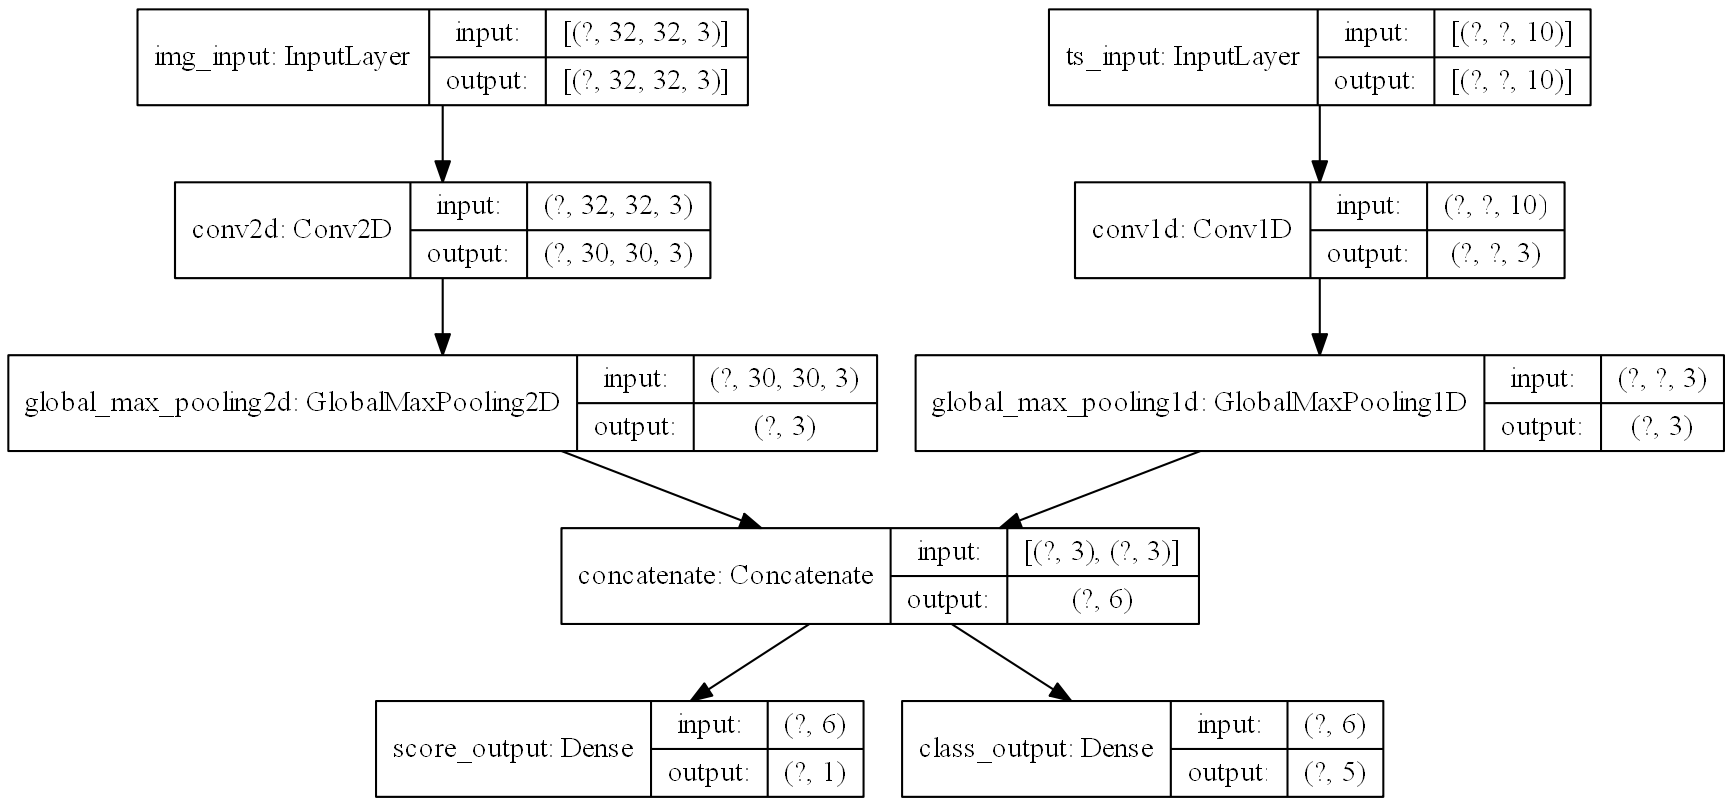

In [28]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True, dpi=150)

In [29]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)])

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=[[keras.metrics.MeanAbsolutePercentageError(),
              keras.metrics.MeanAbsoluteError()],
             [keras.metrics.CategoricalAccuracy()]])

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]})

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weights={'score_output': 2., 'class_output': 1.})

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy(from_logits=True)])

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output':keras.losses.CategoricalCrossentropy(from_logits=True)})

In [34]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy(from_logits=True)])

# 构造虚拟数据
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# 列表方式
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# 字典方式
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 6s 59ms/sample - loss: 7.9416 - score_output_loss: 2.8117 - class_output_loss: 4.9897
Epoch 2/3
100/100 [==============================] - 0s 375us/sample - loss: 6.4782 - score_output_loss: 1.3994 - class_output_loss: 5.0691
Epoch 3/3
100/100 [==============================] - 0s 363us/sample - loss: 5.8427 - score_output_loss: 1.2465 - class_output_loss: 4.6070
Train on 100 samples
Epoch 1/3
100/100 [==============================] - 0s 374us/sample - loss: 5.4004 - score_output_loss: 0.6153 - class_output_loss: 4.6934
Epoch 2/3
100/100 [==============================] - 0s 382us/sample - loss: 5.1590 - score_output_loss: 0.4449 - class_output_loss: 4.8196
Epoch 3/3
100/100 [==============================] - 0s 330us/sample - loss: 5.0042 - score_output_loss: 0.3273 - class_output_loss: 4.5378


In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=3)

Train for 2 steps
Epoch 1/3
2/2 [==============================] - 1s 452ms/step - loss: 4.9104 - score_output_loss: 0.1947 - class_output_loss: 4.7098
Epoch 2/3
2/2 [==============================] - 0s 16ms/step - loss: 4.8905 - score_output_loss: 0.1724 - class_output_loss: 4.7156
Epoch 3/3
2/2 [==============================] - 0s 18ms/step - loss: 4.8706 - score_output_loss: 0.1627 - class_output_loss: 4.7040


In [36]:
class LossHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs):
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))

In [ ]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}', # 检查点文件保存路径
        save_best_only=True, # monitor设置的监视指标变化时，保存检查点文件并覆盖已保存的检查点文件
        monitor='val_loss',
        verbose=1)
]

model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

In [ ]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [ ]:
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='/full_path_to_your_logs')
model.fit(dataset, epochs=10, callbacks=[tensorboard_cbk])

In [37]:
# 定义模型
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# 实例化优化器
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# 实例化损失函数
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 准备训练数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [38]:
epochs = 3

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    # 在数据集上以批处理大小迭代
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # 打开GradientTape来记录前向传递过程中运行的操作，这支持自动微分。
        with tf.GradientTape() as tape:

            # 通过该层前向传递。图层应用于其输入的操作将记录在GradientTape上。
            logits = model(x_batch_train, training=True)  # 小批量的Logit

            # 计算小批量数据的损失
            loss_value = loss_fn(y_batch_train, logits)

        # 使用梯度自动获取可训练变量的loss梯度。
        grads = tape.gradient(loss_value, model.trainable_weights)

        # 通过更新变量的值来最大程度地减少损失，从而执行梯度下降
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # 每200个batch打印一次日志
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 2.34749174118042
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2381997108459473
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.14272403717041
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.0917067527770996
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.0158851146698
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.8915430307388306
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8089723587036133
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.6553739309310913
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 1.618318796157837
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.6097385883331299
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.3778656721115112
Seen so far: 25664 s

In [40]:
# 定义模型
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# 实例化优化器
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# 实例化损失函数
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 准备训练数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 设置指标
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# 准备验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

In [41]:
epochs = 3

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)  # 小批量的Logit
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # 更新训练指标
        train_acc_metric(y_batch_train, logits)

        # 每200个batch打印一次日志
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))
            
    # 每个epoch之后打印指标
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    # 每个epoch之后重置指标
    train_acc_metric.reset_states()

    # 在每个epoch结束时运行一个验证循环
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        # 通过指标更新
        val_acc_metric(y_batch_val, val_logits)
    
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.378870964050293
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2256104946136475
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.1705665588378906
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.1625301837921143
Seen so far: 38464 samples
Training acc over epoch: 0.23837999999523163
Validation acc: 0.3903000056743622
Start of epoch 1
Training loss (for one batch) at step 0: 2.026705741882324
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9328038692474365
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.943723201751709
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7952020168304443
Seen so far: 38464 samples
Training acc over epoch: 0.4874800145626068
Validation acc: 0.597000002861023
Start of epoch 2
Training loss (for one batch) at step 0: 1.7320666313171387
Seen so far: 64 samples
Training

In [42]:
class ActivityRegularizationLayer(layers.Layer):

    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [43]:
logits = model(x_train)

In [44]:
logits = model(x_train[:64])
print(model.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=6.426128>]


In [45]:
epochs = 3
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)  # 小批量的Logit
            loss_value = loss_fn(y_batch_train, logits)
            
            # 在前向传播过程中添加额外的损失
            loss_value += sum(model.losses)
            
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # 每200个batch打印一次日志
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 8.735221862792969
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.5059332847595215
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.413942337036133
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3521640300750732
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3404712677001953
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3348522186279297
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3144493103027344
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3205440044403076
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.318399429321289
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.316324472427368
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3073883056640625
Seen so far: 256